In [ ]:
# This file contains functions and programs to compute wavefront frames from a recorded interferogram video. 
# It uses two functions named phase_unwrap, _wrapToPi from another file named phase_unwrap

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imageio.v3 as iio
import skimage as ski
import cv2
import os
from scipy.ndimage import label, center_of_mass
import glob
from ipynb.fs.full.phase_unwrap import phase_unwrap, _wrapToPi
import matplotlib.colors as mcolors

In [4]:
%cd D:\Europhotonics Masters\MATLAB\LAM\03_April part2

D:\Europhotonics Masters\MATLAB\LAM\03_April part2


In [7]:
# function to find the brightest blob
# Read the first frame to find the brightest blob
# blob_y, blob_x = best_blob
def brightest_blob(interferogram_video):
    # input: the recorded interferogram video
    cap = cv2.VideoCapture(interferogram_video)
    ret, first_frame = cap.read()
    if not ret:
        print("Failed to read the first frame.")
        cap.release()
        return None

    print("First frame read successfully.")

    # Convert to grayscale and normalize
    gray_first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    image_crop = gray_first_frame[400:820, 400:820]  # Crop to remove boundary effects
    
    # Compute FFT of the first frame
    image_av = np.mean(image_crop)
    image_crop_av = image_crop - image_av
    fft_shift_image_crop = np.fft.fftshift(np.fft.fft2(image_crop_av))

    # Find the brightest blob in FFT magnitude spectrum (by selecting the pixels with 98% of maximum intensity)
    magnitude_spectrum_crop = np.log1p(np.abs(fft_shift_image_crop))
    threshold = np.max(magnitude_spectrum_crop) * 0.98
    binary_mask = magnitude_spectrum_crop > threshold

    # Label and find blob positions
    labeled, num_features = label(binary_mask)
    if num_features == 0:
        print("No blobs found in the frequency domain.")
        cap.release()
        return None

    blob_centers = center_of_mass(binary_mask, labeled, range(1, num_features+1))
    best_blob = tuple(map(int, blob_centers[0]))  # Convert to int

    print("Brightest Blob Position:", best_blob)
    return best_blob

In [8]:
# function to compute wavefront for a single frame 

def compute_wavefront_frame(interferogram_frame, blob_x, blob_y, blob_size):
    #input: interferogram_frame- the interferogram frame from the recorded video of which you want to compute wavefront frame
    #blob_x, blob_y- the x,y coordinates of the brightest blob in fourier space which you want to shift to the center
    #blob_size- the size of the pixels around blob that you want to shift
    
    # Define grid for tilt removal
    x = np.linspace(1, 420, 420)
    y = np.linspace(1, 420, 420)
    X, Y = np.meshgrid(x, y)
    A = np.vstack([X.flatten(), Y.flatten(), np.ones_like(X.flatten())]).T  # Reshape for fitting

    # Process the frame
    gray_img = cv2.cvtColor(interferogram_frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    image_crop = gray_img[400:820, 400:820]
        
    # FFT Processing
    image_av = np.mean(image_crop)
    fft_shift_image_crop = np.fft.fftshift(np.fft.fft2(image_crop - image_av))


    # Isolate the brightest blob in the frequency domain
    isolated_fft = np.zeros_like(fft_shift_image_crop, dtype=np.complex64)
    isolated_fft[210 - blob_size//2: 210 + blob_size//2, 210 - blob_size//2: 210 + blob_size//2] = \
    fft_shift_image_crop[blob_x - blob_size//2:blob_x + blob_size//2, blob_y - blob_size//2:blob_y + blob_size//2]

    # Inverse FFT to get phase
    ifft_shift = np.fft.ifftshift(isolated_fft)
    reconstructed_image = np.fft.ifft2(ifft_shift)
    phi2 = np.arctan2(reconstructed_image.imag, reconstructed_image.real)
    # Phase unwrapping and tilt removal
    phase_data = phase_unwrap(phi2)
    a, b, c = np.linalg.lstsq(A, phase_data.flatten(), rcond=None)[0]
    wavefront = phase_data - (a * X + b * Y + c)
    return wavefront

First frame read successfully.


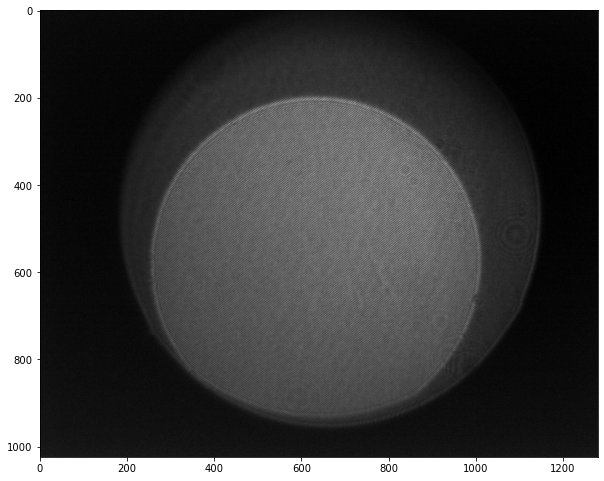

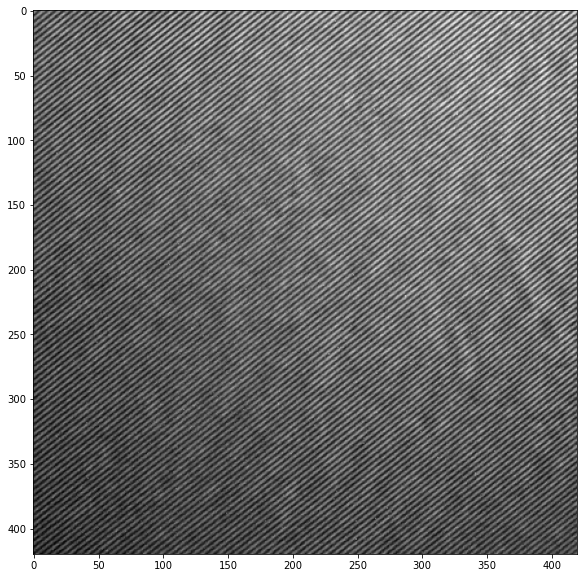

(420, 420)


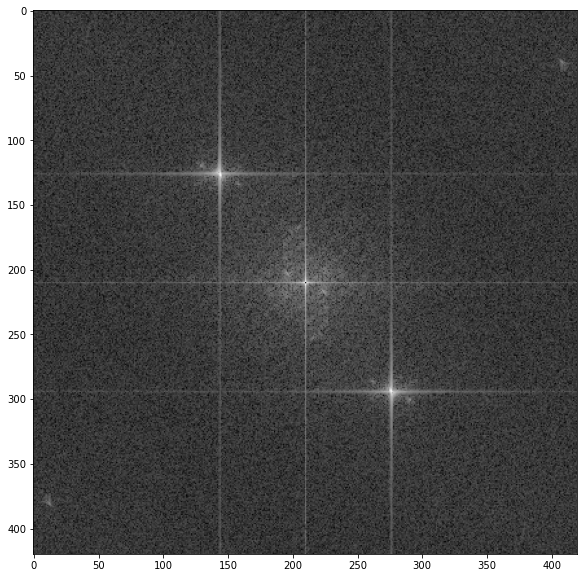

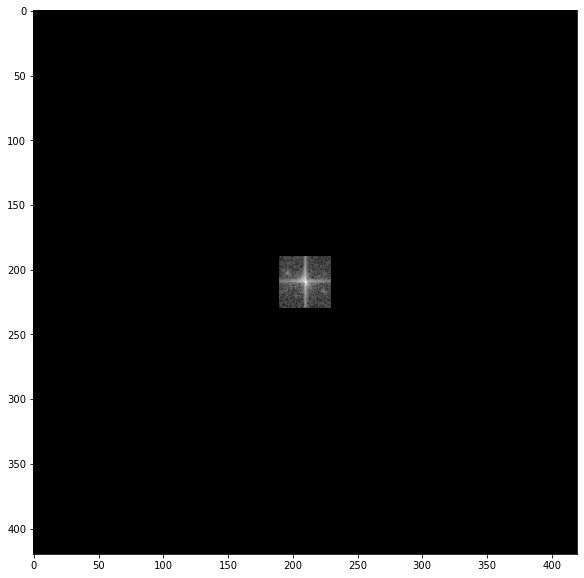

(420, 420)
Terminated after 1 iterations
(420, 420)


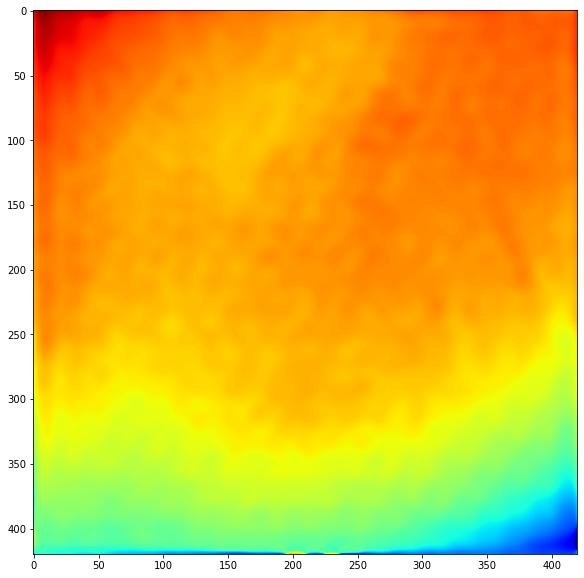

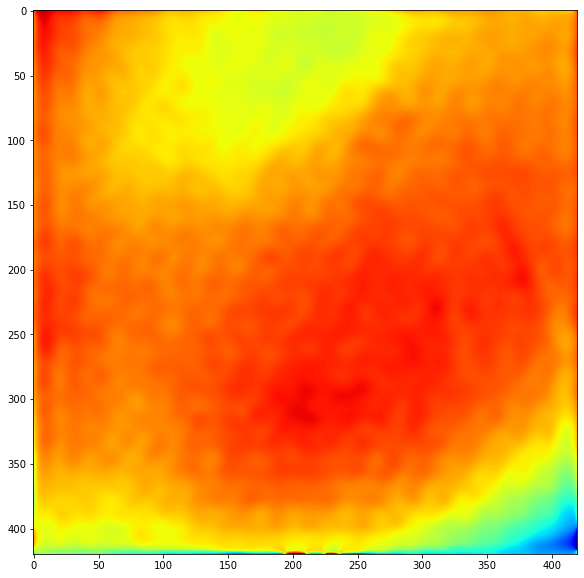

In [9]:
# # Define grid for tilt removal
# x = np.linspace(1, 420, 420)
# y = np.linspace(1, 420, 420)
# X, Y = np.meshgrid(x, y)
# A = np.vstack([X.flatten(), Y.flatten(), np.ones_like(X.flatten())]).T  # Reshape for fitting

# cap = cv2.VideoCapture('test_april01.avi')
# ret, first_frame = cap.read()
# if not ret:
#     print("Failed to read the first frame.")
#     cap.release()

# print("First frame read successfully.")
# plt.figure(figsize=(10,10))
# plt.imshow(first_frame, cmap='gray')
# plt.show()
# # Convert to grayscale and normalize
# gray_first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
# image_crop = gray_first_frame[400:820, 400:820]  # Crop to remove boundary effects

# plt.figure(figsize=(10,10))
# plt.imshow(image_crop, cmap='gray')
# plt.show()

# # Compute FFT of the first frame
# image_av = np.mean(image_crop)
# image_crop_av = image_crop - image_av
# print(image_crop_av.shape)
# fft_shift_image_crop = np.fft.fftshift(np.fft.fft2(image_crop_av))
# # Find the brightest blob in FFT magnitude spectrum
# magnitude_spectrum_crop = np.log1p(np.abs(fft_shift_image_crop))
# plt.figure(figsize=(10,10))
# plt.imshow(magnitude_spectrum_crop, cmap='gray')
# plt.show()
# threshold = np.max(magnitude_spectrum_crop) * 0.98

# binary_mask = magnitude_spectrum_crop > threshold

# # Label and find blob positions
# labeled, num_features = label(binary_mask)
# if num_features == 0:
#     print("No blobs found in the frequency domain.")
#     cap.release()

# blob_centers = center_of_mass(binary_mask, labeled, range(1, num_features+1))
# best_blob = tuple(map(int, blob_centers[0]))  # Convert to int
# blob_y, blob_x = best_blob
# blob_size=40
# # Isolate the brightest blob in the frequency domain
# isolated_fft = np.zeros_like(fft_shift_image_crop, dtype=np.complex64)
# isolated_fft[210 - blob_size//2: 210 + blob_size//2, 210 - blob_size//2: 210 + blob_size//2] = \
# fft_shift_image_crop[blob_y - blob_size//2:blob_y + blob_size//2, blob_x - blob_size//2:blob_x + blob_size//2]
# plt.figure(figsize=(10,10))
# plt.imshow(np.log1p(np.abs(isolated_fft)), cmap='gray')
# plt.show()
# print(isolated_fft.shape)
# # Inverse FFT to get phase
# ifft_shift = np.fft.ifftshift(isolated_fft)
# reconstructed_image = np.fft.ifft2(ifft_shift)
# phi2 = np.arctan2(reconstructed_image.imag, reconstructed_image.real)
# # Phase unwrapping and tilt removal
# phase_data = phase_unwrap(phi2)
# print(phase_data.shape)
# a, b, c = np.linalg.lstsq(A, phase_data.flatten(), rcond=None)[0]
# wavefront = phase_data - (a * X + b * Y + c)
# plt.figure(figsize=(10,10))
# plt.imshow(phase_data, cmap='jet')
# plt.show()
# plt.figure(figsize=(10,10))
# plt.imshow(wavefront, cmap='jet')
# plt.show()

In [1]:
# best_blob_y, best_blob_x = brightest_blob('test_april01.avi')
# fr = iio.imread(uri = "first_frame02.jpg")
# ff = compute_wavefront_frame(fr, best_blob_x, best_blob_y, 40)
# plt.imshow(ff, cmap='jet')
# plt.colorbar()
# frame_path = os.path.join("ff.png")
# plt.savefig(frame_path, bbox_inches='tight', pad_inches=0)

# # Save the wavefront (phase values between -3 and 4)
# # np.save("ff1.npy", ff)

In [2]:
# # Later, load it back:
# phase_wavefront_loaded = np.load("ff1.npy")
# plt.imshow(phase_wavefront_loaded)
# plt.colorbar()

In [13]:
# Computing the wavefronts and extracting an output video of wavefronts

# Find the brightest blob
best_blob_y, best_blob_x = brightest_blob('test_april01.avi') # compute the brightest blob position

def compute_wavefront_generator(video_path):
    """Generator function to compute wavefronts and yield one at a time."""
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        wavefront = compute_wavefront_frame(frame, best_blob_x, best_blob_y, 40)  # Compute wavefront for this frame
        yield wavefront  # Yield instead of storing
        
        frame_idx += 1

    cap.release()

# Step 1: Memory-map file
filename = os.path.abspath("zero01.dat")
num_frames = 1000  # Adjust based on actual frames
height, width = 420, 420  # Adjust based on wavefront size

wave_front = np.memmap(filename, dtype=np.float32, mode='w+', shape=(num_frames, height, width))

# Step 2: Compute and directly store in memory-mapped file
for i, wavefront in enumerate(compute_wavefront_generator('test_april01.avi')):
    wave_front[i] = wavefront  # Directly writing to memmap

# Compute min/max globally for consistent color scaling
vmin, vmax = wave_front.min(), wave_front.max()

# Step 3: Create output video
output_path = "wavefront_video_4000_all.mp4"
frame_rate = 20
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
frame_size = (width, height)
out = cv2.VideoWriter(output_path, fourcc, frame_rate, frame_size)

# Step 4: Plot and save frames
temp_dir = "zero01"
os.makedirs(temp_dir, exist_ok=True)

for i in range(2500):
    fig, ax = plt.subplots()
    cax = ax.imshow(wave_front[i], cmap='jet', vmin=vmin, vmax=vmax)
    plt.axis('off')

    frame_path = os.path.join(temp_dir, f"frame_{i:04d}.png")
    plt.savefig(frame_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Convert to OpenCV image & write to video
    frame = cv2.imread(frame_path)
    frame = cv2.resize(frame, frame_size)
    out.write(frame)

out.release()
print(f"Wavefront video saved as {output_path}")

First frame read successfully.
Brightest Blob Position: (127, 144)
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Terminated after 1 iterations
Ter

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [14]:
# Saving wavefronts in .npy format (occupies less storage)
# Find the brightest blob
best_blob_y, best_blob_x = brightest_blob('Test01.avi') # compute the brightest blob position

def compute_wavefront_generator(video_path):
    #"""Generator function to compute wavefronts and yield one at a time."""
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        wavefront = compute_wavefront_frame(frame, best_blob_x, best_blob_y, 40)  # Compute wavefront for this frame
        yield wavefront  # Yield instead of storing
        
        frame_idx += 1

    cap.release()

# Step 1: Memory-map file
filename = os.path.abspath("zero1.dat")
num_frames = 2700  # Adjust based on actual frames
height, width = 420, 420  # Adjust based on wavefront size

wave_front = np.memmap(filename, dtype=np.float32, mode='w+', shape=(num_frames, height, width))

# Step 2: Compute and directly store in memory-mapped file
for i, wavefront in enumerate(compute_wavefront_generator('Test01.avi')):
    wave_front[i] = wavefront  # Directly writing to memmap

print(wave_front.shape)

# Step 4: Plot and save frames
for i, wavefront in enumerate(wave_front):
    frame_path = os.path.join(temp_dir, f"frame_{i:04d}.npy")
    np.save(f"frame_{i:04d}.npy", wavefront)

(1000, 420, 420)


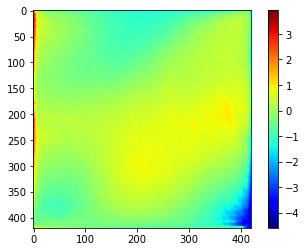

In [51]:
# Later, load it back:
f = np.load("frame_0000.npy", allow_pickle=True)
plt.imshow(f, cmap='jet')
plt.colorbar()